In [1]:
import os

num_chains = 10
n_devices = min(os.cpu_count(), num_chains)
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={n_devices}'


from typing import Tuple, Dict, Any

import pandas as pd
import numpy as np

import jax.numpy as jnp

from scipy.stats import norm

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from namgcv.basemodels.bnam import BayesianNAM
from namgcv.configs.bayesian_nam_config import DefaultBayesianNAMConfig
from namgcv.configs.bayesian_nn_config import DefaultBayesianNNConfig

import pickle

2025-03-03 09:07:21,215 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2025-03-03 09:07:21,215 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-03-03 09:07:21,230 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
2025-03-03 09:07:21,748 - datasets - INFO - PyTorch version 2.6.0 available.
2025-03-03 09:07:21,748 - datasets - INFO - JAX version 0.4.28 available.


In [2]:
GREEN_RGB_COLORS = [
    '#004c00',  # '#004e00', '#005000', '#005100', '#005300',
    # '#005500', # '#005700', '#005900', '#005a00', '#005c00',
    '#005e00',  # '#006000', '#006200', '#006300', '#006500',
    # '#006700', # '#006900', '#006b00', '#006c00', '#006e00',
    '#007000',  # '#007200', '#007400', '#007500', '#007700',
    # '#007900', # '#007b00', '#007d00', '#007e00', '#008000',
    '#008200',  # '#008400', '#008600', '#008800', '#008900',
    # '#008b00', # '#008d00', '#008f00', '#009100', '#009200',
    '#009400',  # '#009600', '#009800', '#009a00', '#009b00',
    # '#009d00', # '#009f00', '#00a100', '#00a300', '#00a400',
    '#00a600',  # '#00a800', '#00aa00', '#00ac00', '#00ad00',
    # '#00af00', # '#00b100', '#00b300', '#00b500', '#00b600',
    '#00b800',  # '#00ba00', '#00bc00', '#00be00', '#00bf00',
    # '#00c100', # '#00c300', '#00c500', '#00c700', '#00c800',
    '#00ca00',  # '#00cc00', '#00ce00', '#00d000', '#00d100',
    # '#00d300', # '#00d500', '#00d700', '#00d900', '#00da00',
    '#00dc00',  # '#00de00', '#00e000', '#00e200', '#00e300',
    # '#00e500', # '#00e700', '#00e900', '#00eb00', '#00ec00',
    '#00ee00',  # '#00f000', '#00f200', '#00f400', '#00f500',
    # '#00f700', # '#00f900', '#00fb00', '#00fd00', '#00ff00'
]

In [3]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(12, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):
            # eu = np.std(np.mean(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(np.var(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(aleatoric_uncertainty[f"{feature_name}/{feature_name}_num_subnetwork_sigma"])

            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in [0, 1]:
                mean_param_contribution = mean_contribution_all_params[:, j]

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]

                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                # if j == 0:
                #     if feature_name == "numerical_1":
                #         true_effect = (feature_values_sorted) ** 2
                #     elif feature_name == "numerical_2":
                #         true_effect =np.exp(feature_values_sorted**3)
                #     elif feature_name == "numerical_3":
                #         true_effect = np.exp((feature_values_sorted) ** 2)
                #     elif feature_name == "numerical_4":
                #         true_effect = np.zeros_like(feature_values_sorted)
                # else:
                #     true_effect = (feature_values_sorted)**2
                #
                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax[i, j]
                )
                #
                # # Proper min–max scaling of the true effect onto [lower, upper]
                # lower_sorted, upper_sorted = (mean_param_contribution_sorted.min(),
                #                               mean_param_contribution_sorted.max())
                # te_min, te_max = true_effect.min(), true_effect.max()
                # true_effect_norm = (true_effect - te_min) / (te_max - te_min)  # now in [0,1]
                # true_effect = true_effect_norm * (upper_sorted - lower_sorted) + lower_sorted
                #
                # sns.lineplot(
                #     x=feature_values_sorted,
                #     y=true_effect,
                #     color="black",
                #     linestyle='dashed',
                #     label="True effect",
                #     ax=ax[i,j],
                # )

                uncertainty = np.std(submodel_contributions[feature_name][:, :, j], axis=0)[sorted_idx]
                ax[i,j].fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0]
                for k in range(num_bins):
                    ax[i,j].bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax[i,j].get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax[i,j].set_xlabel(f"{feature_name}", fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=12, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

In [4]:
data = fetch_california_housing()

X = pd.DataFrame(
    data=data.data,
    columns=data.feature_names
)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80
...,...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96


In [6]:
# scaler_X = StandardScaler()
# X_train_scaled = scaler_X.fit_transform(X_train.values)
# X_test_scaled = scaler_X.transform(X_test.values)
# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

input_dim = X_train.shape[1]

In [12]:
# ---------------
# Model training.
# ---------------
import numpyro
numpyro.set_host_device_count(
    DefaultBayesianNAMConfig().num_chains
)
model = BayesianNAM(
    cat_feature_info={},
    num_feature_info={
        feature_name: {
            "input_dim": 1,
            "output_dim": 2
        } for feature_name in X_train.columns
    },
    num_classes=1,
    config=DefaultBayesianNAMConfig(),
    subnetwork_config=DefaultBayesianNNConfig()
)

model.train_model(
    num_features={
        feature_name: jnp.array(
            X_train.iloc[:, col_idx]
        ) for col_idx, feature_name in enumerate(X_train.columns)
    },
    cat_features={},
    target=jnp.array(y_train),
    dataset_name="california_housing"
)


2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,581 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-03 09:07:25,740 - namgcv.basemodels.bnam - INFO - 
+---------------------------------------+
| Bayesian NAM successfully initialized.|
+---------------------------------------+

2025-03-03 09:07:25,740 - namgcv.basemodels.bnam - INF

Epoch 2 | NLL=(Train:[6.534, 4.283, 5.394, 5.412, 4.253, 5.628, 4.451, 3.385, 4.997, 5.377], Val:[6.534, 4.283, 5.394, 5.412, 4.253, 5.628, 4.451, 3.385, 4.997, 5.377]) | RMSE=(Train:[5.291, 2.576, 1.547, 1.625, 1.839, 1.641, 1.899, 1.472, 1.382, 2.212], Val:[5.291, 2.576, 1.547, 1.625, 1.839, 1.641, 1.899, 1.472, 1.382, 2.212]):   3%|▎         | 3/100 [00:57<30:48, 19.06s/it]  
  3%|▎         | 3/100 [00:57<30:48, 19.06s/it]


2025-03-03 09:08:32,248 - namgcv.basemodels.bnam - INFO - (Test NLL=[6.542, 4.307, 5.385, 5.439, 4.257, 5.676, 4.465, 3.414, 4.984, 5.381] | Test RMSE=[5.293, 2.564, 1.541, 1.614, 1.921, 1.649, 1.954, 1.472, 1.410, 2.256])
2025-03-03 09:08:32,369 - namgcv.basemodels.bnam - INFO - Finished warm-start training for chain 1 of 10.
2025-03-03 09:08:32,559 - namgcv.basemodels.bnam - INFO - Deep Ensemble 0 saved to C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\..\bnam_de_warmstart_checkpoints\warmstart
2025-03-03 09:08:32,701 - namgcv.basemodels.bnam - INFO - Deep Ensemble 1 saved to C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\..\bnam_de_warmstart_checkpoints\warmstart
2025-03-03 09:08:32,850 - namgcv.basemodels.bnam - INFO - Deep Ensemble 2 saved to C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\..\bnam_de_warmstart_checkpoin

KeyboardInterrupt: 

In [ ]:
num_features = {
    feature_name: jnp.array(
        X_test.iloc[:, col_idx]
    ) for col_idx, feature_name in enumerate(X_test.columns)
}
cat_features = {}

final_params, submodel_contributions = model.predict(
    num_features=num_features,
    cat_features=cat_features,
)

In [12]:
final_loc = final_params[..., 0].mean(axis=0)
final_scale = final_params[..., 1].mean(axis=0)

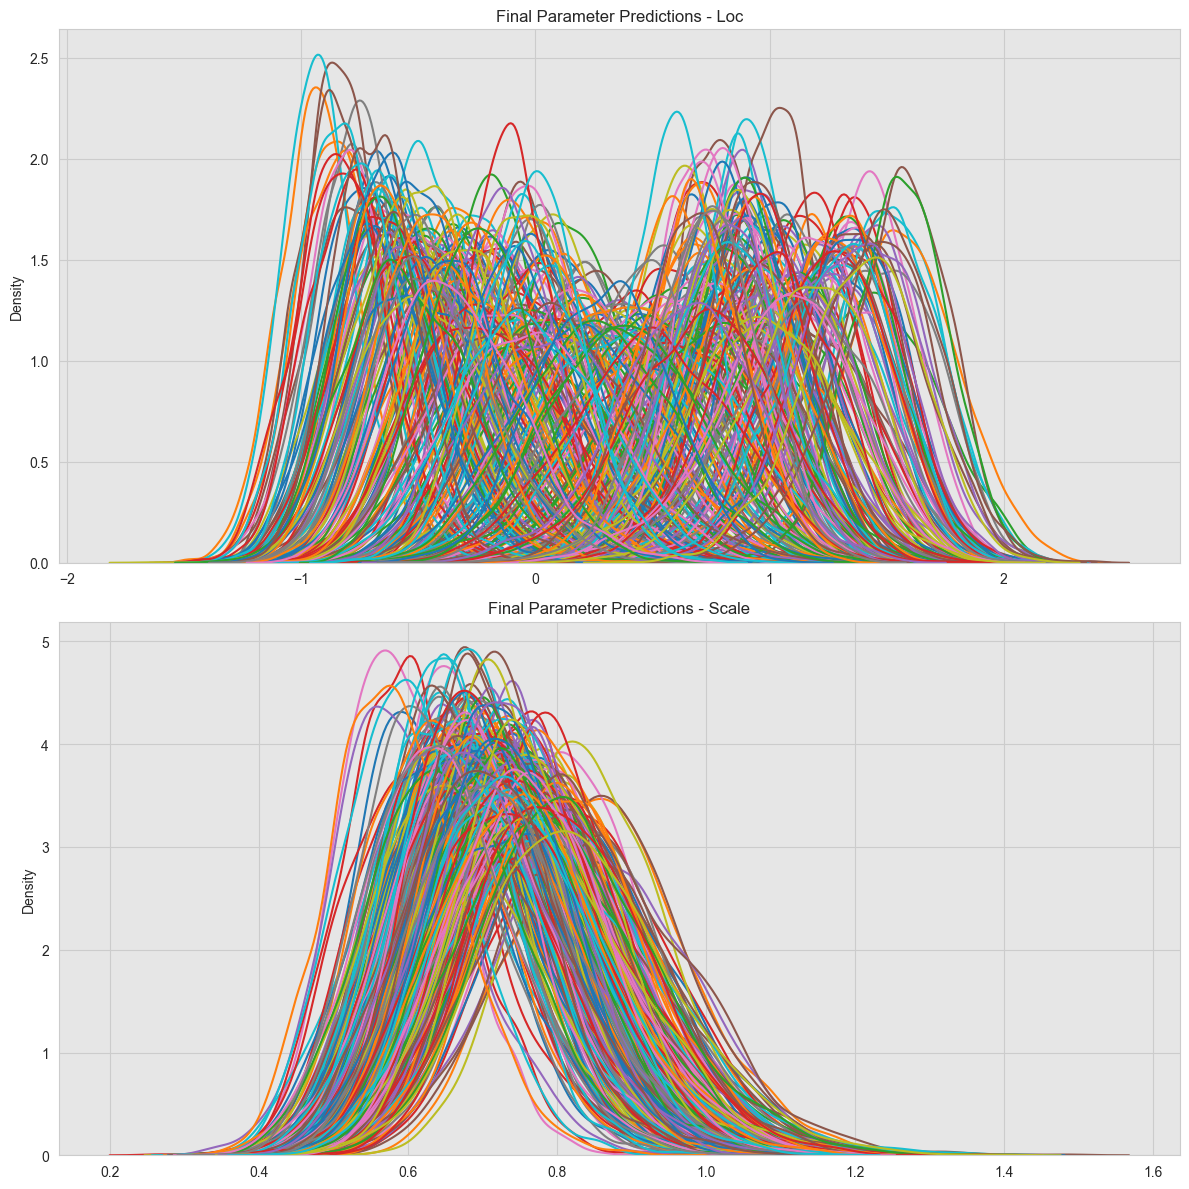

In [31]:
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6 * 2))
for i, (final_param_name, final_param_pred) in enumerate(
        zip(
            ["loc", "scale"],
            [final_params[..., 0], final_params[..., 1]]
        )
):
    # for j in range(final_param_pred.shape[1]):
    #     sns.kdeplot(
    #         final_param_pred[:, j],
    #         ax=ax[i]
    #     )
    sns.kdeplot(
        final_param_pred.mean(axis=0),
        ax=ax[i]
    )

    ax[i].set_title(f"Final Parameter Predictions - {final_param_name.title()}", fontsize=12)
    ax[i].grid(True)
plt.tight_layout()
plt.show()

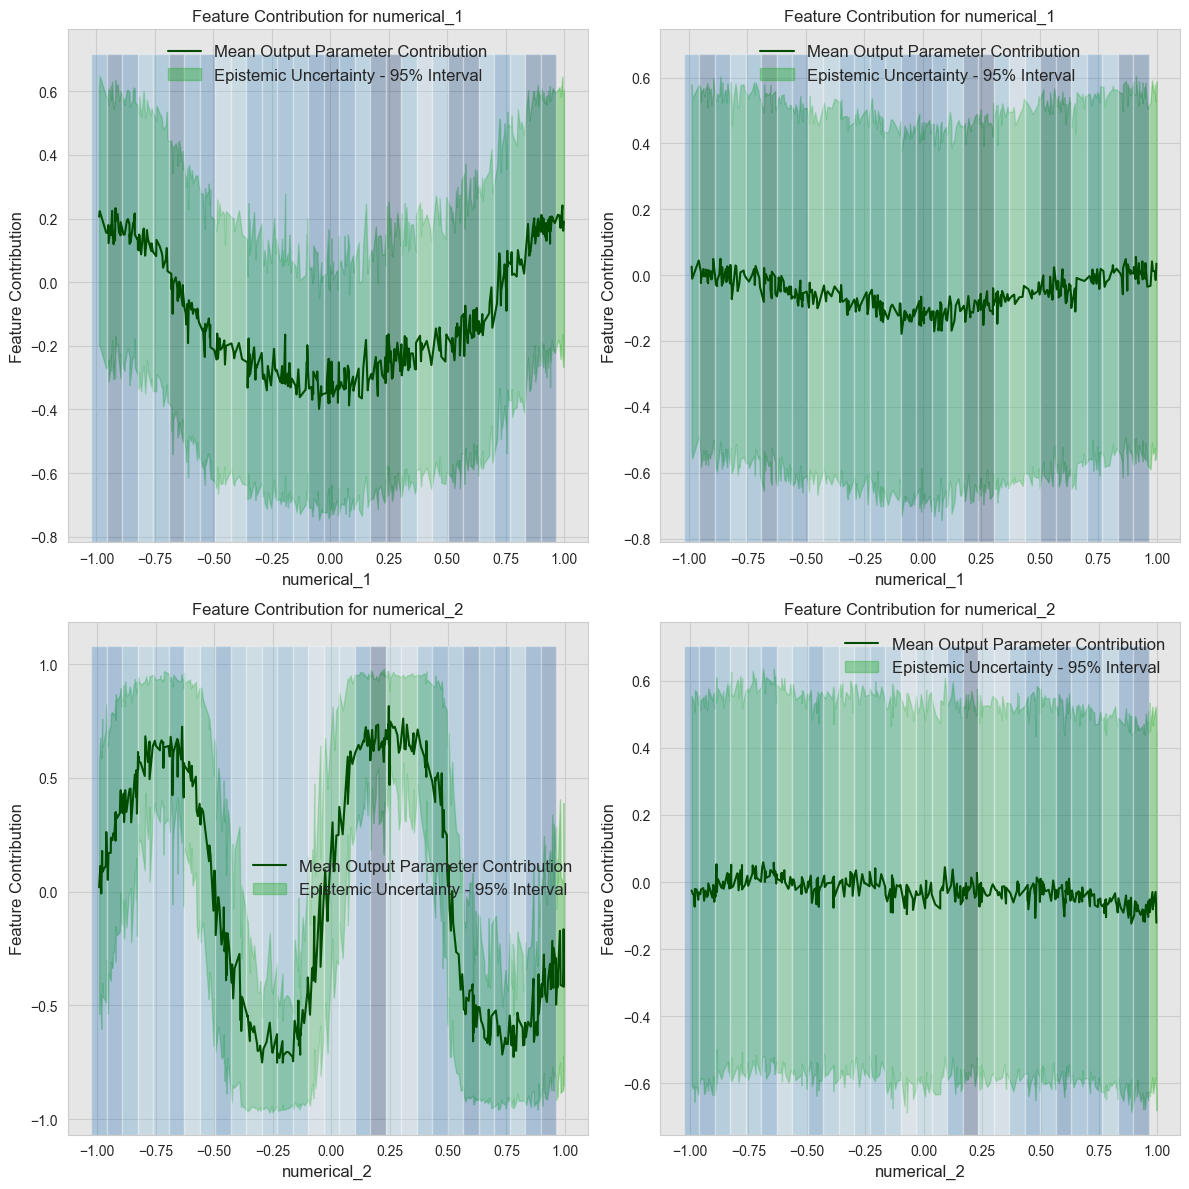

C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_11200\3106727816.py:164: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


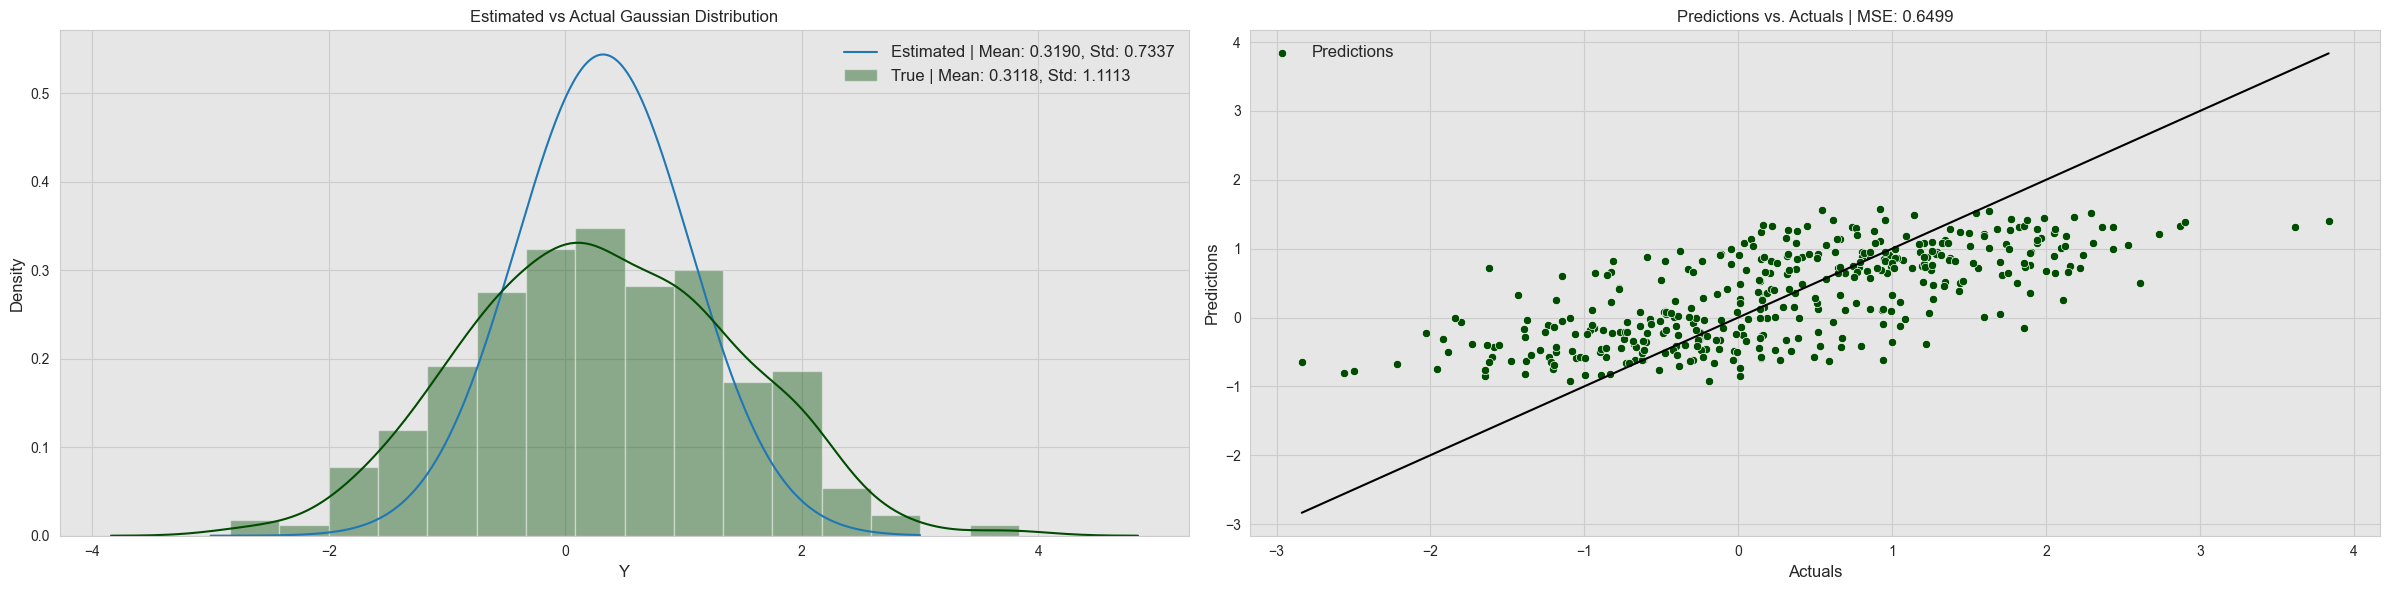

In [24]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(12, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):
            # eu = np.std(np.mean(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(np.var(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(aleatoric_uncertainty[f"{feature_name}/{feature_name}_num_subnetwork_sigma"])

            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in [0, 1]:
                mean_param_contribution = mean_contribution_all_params[:, j]

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]

                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                # if j == 0:
                #     if feature_name == "numerical_1":
                #         true_effect = (feature_values_sorted) ** 2
                #     elif feature_name == "numerical_2":
                #         true_effect =np.exp(feature_values_sorted**3)
                #     elif feature_name == "numerical_3":
                #         true_effect = np.exp((feature_values_sorted) ** 2)
                #     elif feature_name == "numerical_4":
                #         true_effect = np.zeros_like(feature_values_sorted)
                # else:
                #     true_effect = (feature_values_sorted)**2
                #
                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax[i, j]
                )
                #
                # # Proper min–max scaling of the true effect onto [lower, upper]
                # lower_sorted, upper_sorted = (mean_param_contribution_sorted.min(),
                #                               mean_param_contribution_sorted.max())
                # te_min, te_max = true_effect.min(), true_effect.max()
                # true_effect_norm = (true_effect - te_min) / (te_max - te_min)  # now in [0,1]
                # true_effect = true_effect_norm * (upper_sorted - lower_sorted) + lower_sorted
                #
                # sns.lineplot(
                #     x=feature_values_sorted,
                #     y=true_effect,
                #     color="black",
                #     linestyle='dashed',
                #     label="True effect",
                #     ax=ax[i,j],
                # )

                uncertainty = np.std(submodel_contributions[feature_name][:, :, j], axis=0)[sorted_idx]
                ax[i,j].fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0]
                for k in range(num_bins):
                    ax[i,j].bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax[i,j].get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax[i,j].set_xlabel(f"{feature_name}", fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=12, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

# -----------------
# Results analysis.
# -----------------
interaction_feature_information = {}
all_features = {**num_features, **cat_features}
for interaction_name in submodel_contributions.keys():
    if ":" not in interaction_name:
        continue

    feature_names = interaction_name.split(":")
    interaction_feature_information[interaction_name] = jnp.concatenate(
        [jnp.expand_dims(all_features[name], axis=-1) for name in feature_names],
        axis=-1
    )

plot_feature_contributions(
    num_features=num_features,
    cat_features=cat_features,
    interaction_features=interaction_feature_information,
    submodel_contributions=submodel_contributions
)

sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12*2, 6))
x = np.linspace(-3, 3, 1000)
ax[0].plot(
    x,
    norm.pdf(
        x,
        loc=final_loc.mean(),
        scale=final_scale.mean()
    ),
    label=f"Estimated | "
          f"Mean: {final_loc.mean():.4f}, "
          f"Std: {final_scale.mean():.4f}",
)
# Plot the distribution of y_test.
sns.distplot(
    y_test,
    color=GREEN_RGB_COLORS[0],
    label=f"True | "
          f"Mean: {y_test.mean():.4f}, "
          f"Std: {y_test.std():.4f}",
    ax=ax[0],
    hist=True
)
ax[0].set_title("Estimated vs Actual Gaussian Distribution", fontsize=12)
ax[0].set_xlabel("Y", fontsize=12)
ax[0].set_ylabel("Density", fontsize=12)
ax[0].legend(loc='best', fontsize=12, frameon=False)
ax[0].grid(True)

# Plot the predictions vs. actuals.
# Plot the y=x line dotted.
sns.lineplot(
    x=y_test,
    y=y_test,
    color="black",
)
sns.scatterplot(
    x=y_test,
    y=final_loc,
    color=GREEN_RGB_COLORS[0],
    label="Predictions",
    ax=ax[1]
)
ax[1].set_xlabel("Actuals", fontsize=12)
ax[1].set_ylabel("Predictions", fontsize=12)
ax[1].set_title(
    f"Predictions vs. Actuals | "
    f"MSE: {np.mean((y_test - final_loc) ** 2):.4f}",
    fontsize=12
)
ax[1].legend(loc='best', fontsize=12, frameon=False)
ax[1].grid(True)

plt.tight_layout()
plt.show()

2025-02-26 15:12:37,829 - namgcv.basemodels.bnam - INFO - All parameter names in the posterior: 
['contrib_numerical_1', 'contrib_numerical_1:numerical_2', 'contrib_numerical_2', 'final_params', 'intercept', 'numerical_1/dense_0_bias', 'numerical_1/dense_0_kernel', 'numerical_1/dense_1_bias', 'numerical_1/dense_1_kernel', 'numerical_1/layer_norm_0_bias', 'numerical_1/layer_norm_0_scale', 'numerical_1:numerical_2/dense_0_bias', 'numerical_1:numerical_2/dense_0_kernel', 'numerical_1:numerical_2/dense_1_bias', 'numerical_1:numerical_2/dense_1_kernel', 'numerical_1:numerical_2/layer_norm_0_bias', 'numerical_1:numerical_2/layer_norm_0_scale', 'numerical_2/dense_0_bias', 'numerical_2/dense_0_kernel', 'numerical_2/dense_1_bias', 'numerical_2/dense_1_kernel', 'numerical_2/layer_norm_0_bias', 'numerical_2/layer_norm_0_scale']
2025-02-26 15:12:37,993 - namgcv.basemodels.bnam - INFO - numerical_1/layer_norm_0_scale: mean=165.145 | std=1733.025


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:38,619 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/layer_norm_0_scale: mean=-78.485 | std=2183.463


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:39,369 - namgcv.basemodels.bnam - INFO - numerical_2/layer_norm_0_scale: mean=304.682 | std=1691.430


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


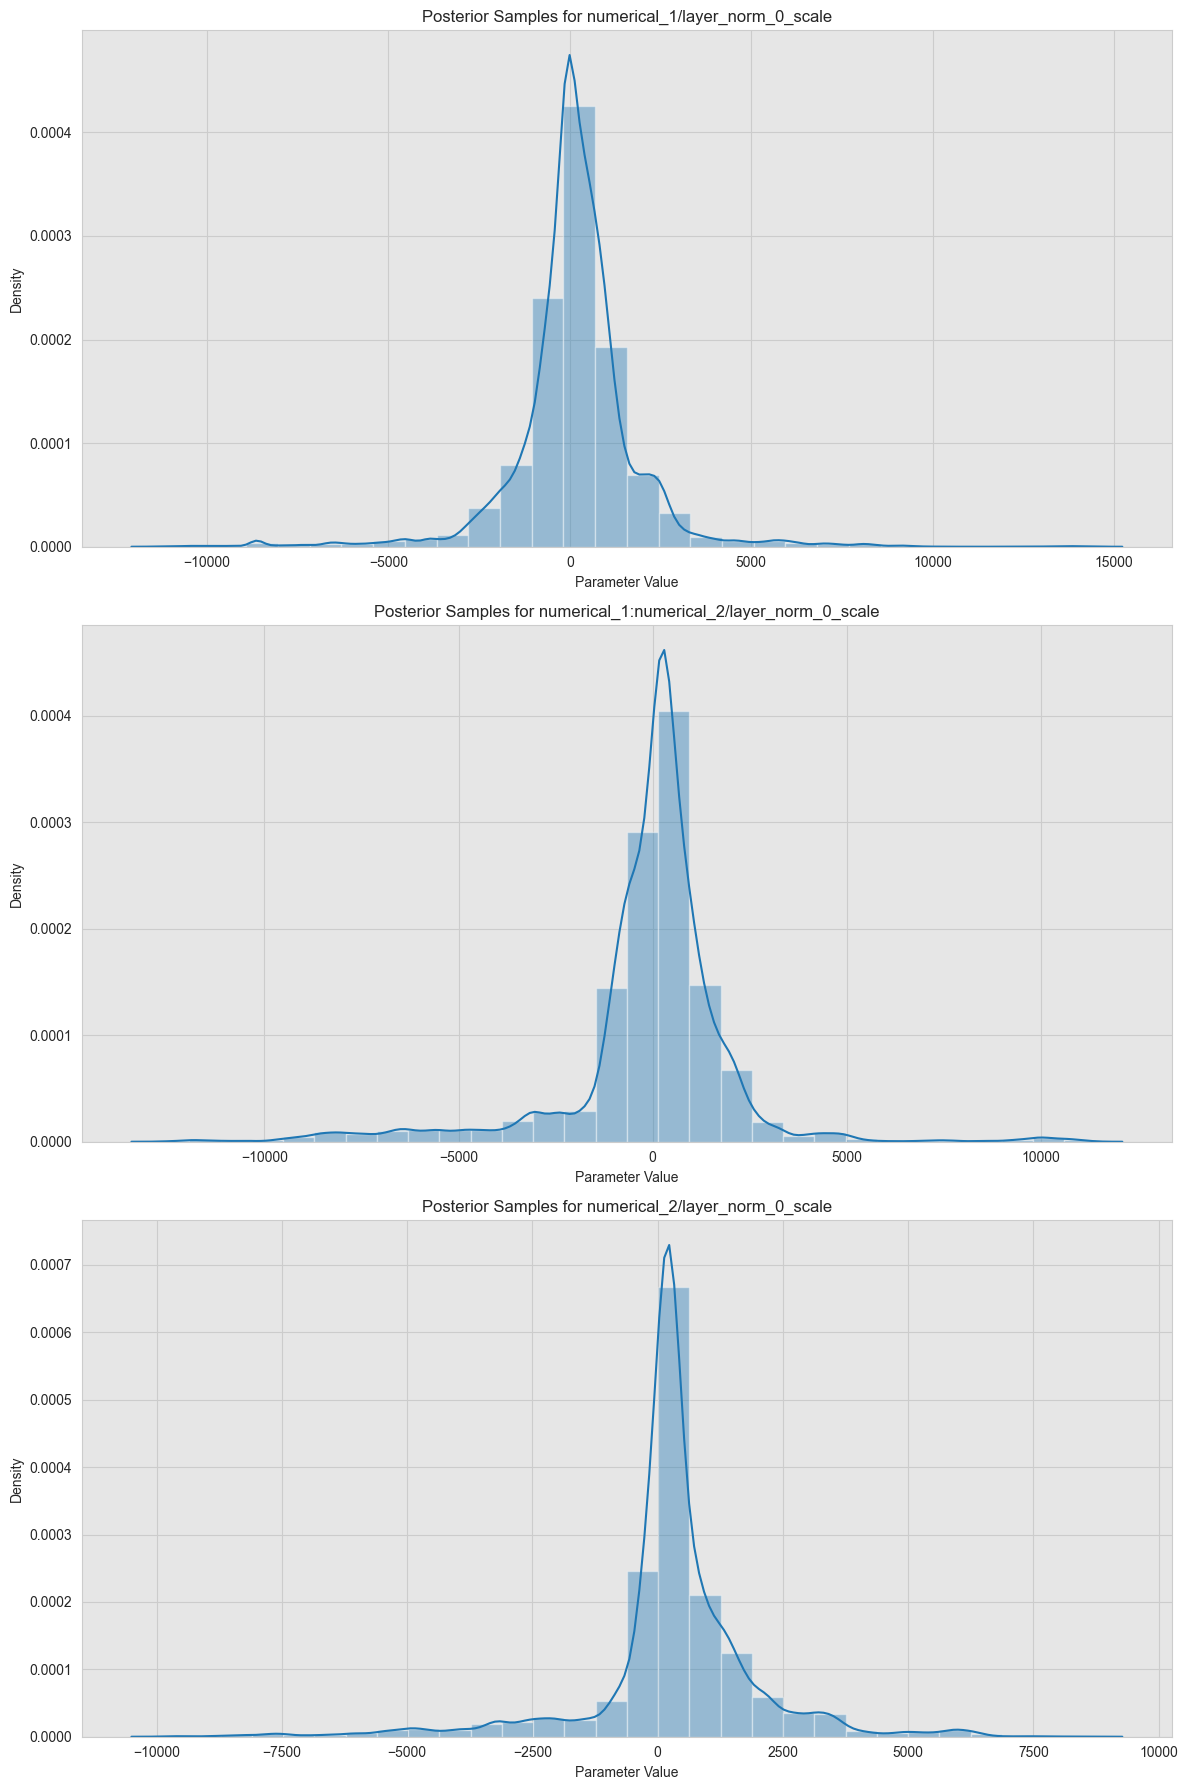

2025-02-26 15:12:40,418 - namgcv.basemodels.bnam - INFO - numerical_1/dense_0_bias: mean=0.004 | std=0.169


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:41,593 - namgcv.basemodels.bnam - INFO - numerical_1/dense_1_bias: mean=0.000 | std=0.182


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:41,920 - namgcv.basemodels.bnam - INFO - numerical_1/layer_norm_0_bias: mean=6.581 | std=1397.267


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:42,731 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/dense_0_bias: mean=0.012 | std=0.184


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:43,651 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/dense_1_bias: mean=0.017 | std=0.170


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:43,951 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/layer_norm_0_bias: mean=-30.962 | std=1442.409


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:44,801 - namgcv.basemodels.bnam - INFO - numerical_2/dense_0_bias: mean=0.010 | std=0.144


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:45,679 - namgcv.basemodels.bnam - INFO - numerical_2/dense_1_bias: mean=0.048 | std=0.186


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:45,919 - namgcv.basemodels.bnam - INFO - numerical_2/layer_norm_0_bias: mean=-37.224 | std=1423.938


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


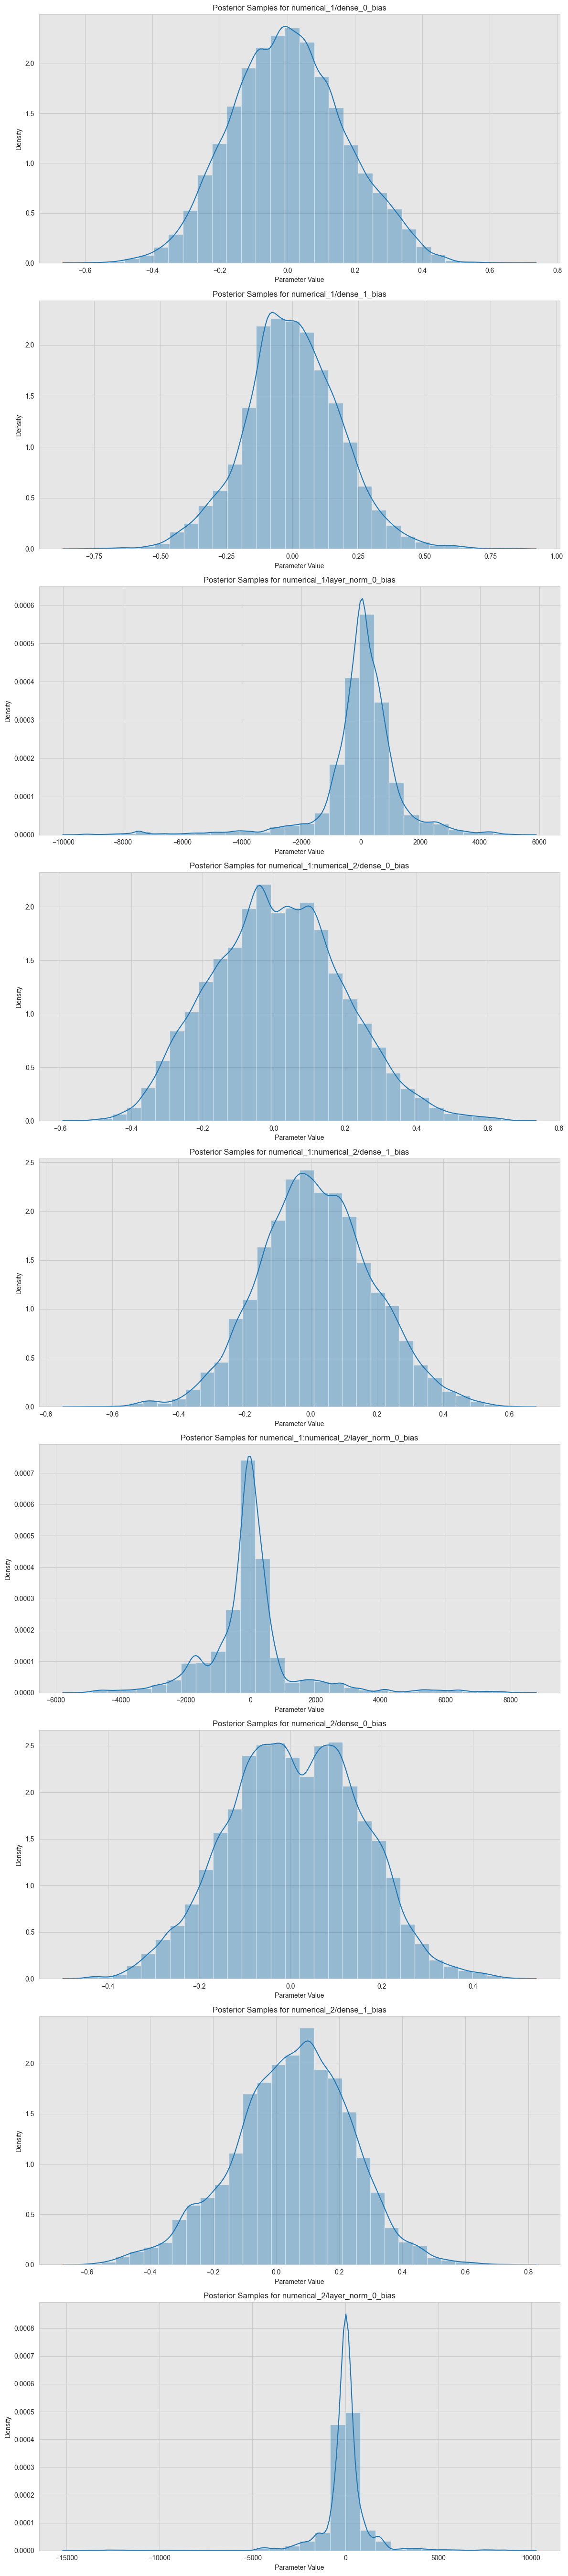

2025-02-26 15:12:47,489 - namgcv.basemodels.bnam - INFO - intercept: mean=0.451 | std=0.850


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


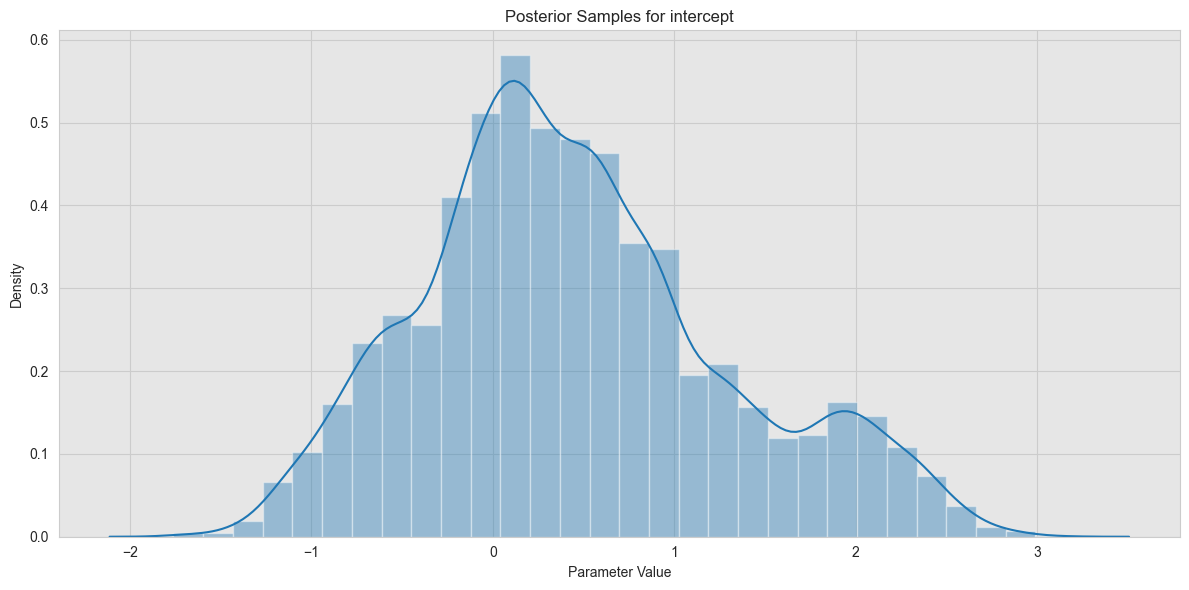

In [14]:
# model.plot_posterior_samples()

2025-02-14 11:47:14,866 INFO:All parameter names in the posterior: 
['contrib_numerical_1', 'contrib_numerical_2', 'final_params', 'intercept', 'numerical_1/numerical_1_num_subnetwork_b0', 'numerical_1/numerical_1_num_subnetwork_b0_scale', 'numerical_1/numerical_1_num_subnetwork_b1', 'numerical_1/numerical_1_num_subnetwork_b1_scale', 'numerical_1/numerical_1_num_subnetwork_b2', 'numerical_1/numerical_1_num_subnetwork_b2_scale', 'numerical_1/numerical_1_num_subnetwork_b3', 'numerical_1/numerical_1_num_subnetwork_b3_scale', 'numerical_1/numerical_1_num_subnetwork_w0', 'numerical_1/numerical_1_num_subnetwork_w0_scale', 'numerical_1/numerical_1_num_subnetwork_w1', 'numerical_1/numerical_1_num_subnetwork_w1_scale', 'numerical_1/numerical_1_num_subnetwork_w2', 'numerical_1/numerical_1_num_subnetwork_w2_scale', 'numerical_1/numerical_1_num_subnetwork_w3', 'numerical_1/numerical_1_num_subnetwork_w3_scale', 'numerical_2/numerical_2_num_subnetwork_b0', 'numerical_2/numerical_2_num_subnetwork_b0_

KeyboardInterrupt: 

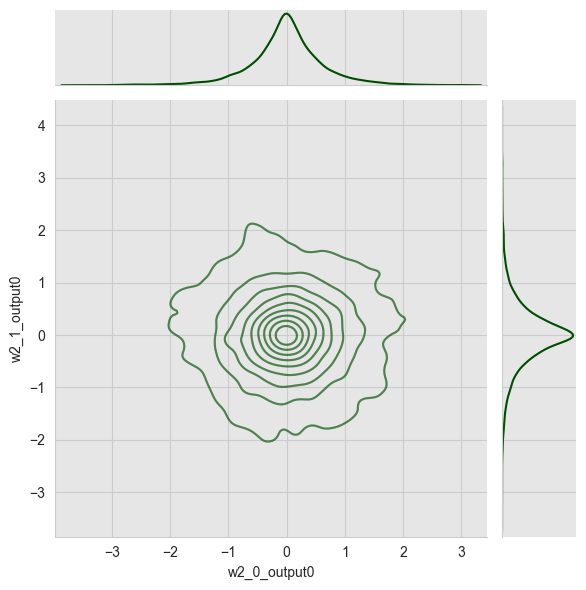

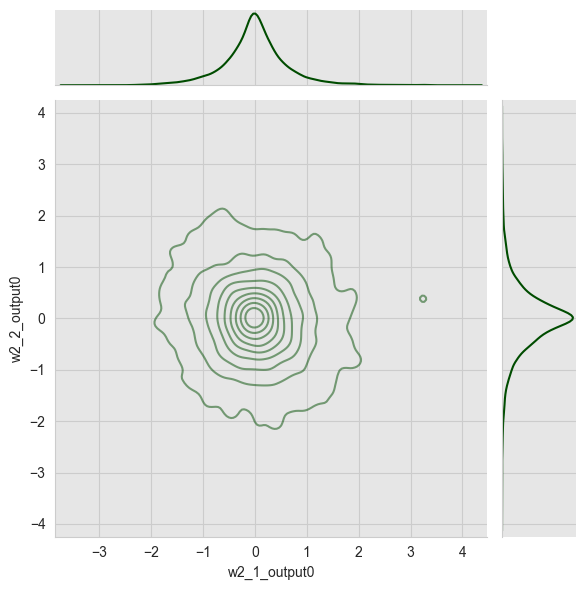

In [13]:
# posterior_param_samples_dict = model._get_posterior_param_samples()
#
# sns.set_style("whitegrid", {"axes.facecolor": ".9"})
# for posterior_params_name, posterior_param_samples in posterior_param_samples_dict.items():
#     if not posterior_param_samples:
#         continue  # Intercept may be None.
#
#     if "weight" not in posterior_params_name:
#         continue  # Only care about weights.
#
#     feature_names = list({
#         key.split("/")[0] for key in posterior_param_samples.keys()
#     })
#     for feature_name in feature_names:
#         param_names = [
#             key for key in posterior_param_samples.keys()
#             if feature_name in key
#         ]  # Parameters for this feature.
#         for i, param_name in enumerate(param_names):
#             if "w2" not in param_name:
#                 continue  # Let's only look at the last layer.
#             if "scale" in param_name:
#                 continue  # Not interested in the hierarchical prior.
#
#             # Convert the posterior samples into a DataFrame for easier plotting.
#             num_samples, num_layer_weights, num_outputs = posterior_param_samples[param_name].shape
#             samples_reshaped = posterior_param_samples[param_name].reshape(
#                 num_samples,
#                 num_layer_weights * num_outputs
#             )
#             column_names = [
#                 f"w2_{i}_output{j}" for j in range(num_outputs) for i in range(num_layer_weights)
#             ]
#             samples_df = pd.DataFrame(samples_reshaped, columns=column_names)
#
#             # Create the plot of bivariate marginals for the last layer weights.
#             for j in range(num_outputs):
#                 for i in range(num_layer_weights - 1):
#                     sns.jointplot(
#                         x=f"w2_{i}_output{j}",
#                         y=f"w2_{i + 1}_output{j}",
#                         data=samples_df,
#                         kind="kde",
#                         alpha=0.5,
#                         color=GREEN_RGB_COLORS[0]
#                     ).plot_joint(sns.kdeplot, color=GREEN_RGB_COLORS[0], alpha=0.3)
#             plt.show()